In [9]:
from source_code import evaluation
import numpy as np
from source_code.evaluation import *
from source_code.comparison import *

from source_code import models
import itertools
import random
from sklearn.decomposition import PCA

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score
from sklearn.preprocessing import Normalizer
import warnings
warnings.filterwarnings("ignore")

%reload_ext autoreload
%autoreload 2

np.random.seed(42)


# Fonctions utiles

In [2]:
def clustering_error(y_true, y_pred):
    return 100*(1 - accuracy_score(y_true, y_pred))

In [3]:
def rearrange_y_pred(y_pred, y_true, Q):
    # Rearrange q such that the number of misclassified nodes is minimized

    # Store all possible permutations of the classes
    permutations = list()
    for permutation in itertools.permutations(range(Q)):
        permutations.append(permutation)

    # Compute the number of misclassified nodes for each permutation
    misclassified_nodes = list()
    for permutation in permutations:
        misclassified_nodes.append(np.sum(y_pred != [permutation[i] for i in y_true]))

    # Find the permutation that minimizes the number of misclassified nodes
    best_permutation = permutations[np.argmin(misclassified_nodes)]

    # Rearrange q according to the best permutation
    new_y_pred = np.zeros_like(y_pred)
    for i in range(Q):
        new_y_pred[y_pred == best_permutation[i]] = i

    return new_y_pred

# AT&T dataset

In [4]:
def load_att_dataset():
  h = 112
  w = 92

  X_load = np.zeros((400, h*w))
  for cl in range(1, 41):
    for i in range(1, 11):
      img = "./att_dataset/s" + str(cl) + "/" + str(i) + ".pgm"
      img = np.array(read_pgm(open(img, 'rb')))
      X_load[10*(cl - 1) + (i-1)] = img
  X_load = X_load / 255

  return X_load.reshape(X_load.shape[0], h, w), h, w

In [5]:
with_normalization = True
with_normalization_str = "yes" if with_normalization else "no"
n_data_by_class = 10
dataset = "att"

X_data, h , w = load_att_dataset()
N_classes = 40
X_data = X_data[:N_classes*10]
X_data = X_data.reshape(X_data.shape[0], h*w)

if with_normalization:
    scaler = Normalizer()
    X_data = scaler.fit_transform(X_data)

labels_true = np.arange(N_classes).repeat(10)

## Original data

In [6]:
kmeans = KMeans(n_clusters=N_classes).fit(X_data)

pred_clusters = kmeans.labels_
print("Original dataset")
print("With normalization : " + with_normalization_str)
print("NMI :", normalized_mutual_info_score(labels_true, pred_clusters))

Original dataset
With normalization : yes
NMI : 0.8238116255820676


## PCA

In [7]:
model = PCA()
X_pca = model.fit_transform(X_data)

kmeans = KMeans(n_clusters=N_classes).fit(X_pca)
pred_clusters = kmeans.labels_
print("PCA")
print("With normalization : " + with_normalization_str)
print("NMI :", normalized_mutual_info_score(labels_true, pred_clusters))

PCA
With normalization : yes
NMI : 0.8488860800229372


## RPCA

In [447]:
model = models.RobustPCA()
L, S = model.fit(X_data)

U, S, Q = np.linalg.svd(L, full_matrices=False)
Q = L @ Q.T

kmeans = KMeans(n_clusters=N_classes).fit(Q)

pred_clusters = kmeans.labels_
err = clustering_error(labels_true, pred_clusters)

print("RPCA")
print("With normalization : " + with_normalization_str)
print("NMI :", normalized_mutual_info_score(labels_true, pred_clusters))

RPCA
With normalization : yes
NMI : 0.858952962929226


## GLPCA

In [11]:
Q_by_beta = dict()
X_data2 = X_data.reshape(X_data.shape[0], h, w)
for idx in range(40):
    X_data_class = X_data2[idx*n_data_by_class:(idx+1)*n_data_by_class]
    G = generate_classification_graph(X_data_class, n_data_by_class)
    for beta in [0, 0.3]:
        GlPCA_model = GLPCA(beta = beta, k = 3)
        Q, U = GlPCA_model.fit(X_data_class, G)
        if Q_by_beta.get(beta) is None:
            Q_by_beta[beta] = Q
        else:
            Q_by_beta[beta] = np.concatenate((Q_by_beta[beta], Q), axis=0)

In [14]:
ARI_list = []
NMI_list = []
error_list = []

kmeans = KMeans(n_clusters=40).fit(Q_by_beta[0.3])
labels_pred = kmeans.labels_
print("GLPCA")
print("With normalization : " + with_normalization_str)
print("NMI :", normalized_mutual_info_score(labels_true, labels_pred))

GLPCA
With normalization : yes
NMI : 0.4447745894836239


## RGLPCA

In [23]:
RGLPCA_Q_by_beta = dict()
X_data2 = X_data.reshape(X_data.shape[0], h, w)
for idx in range(40):
    X_data_class = X_data2[idx*n_data_by_class:(idx+1)*n_data_by_class]
    G = generate_classification_graph(X_data_class, n_data_by_class)
    RGlPCA_model = RGLPCA(beta = 0.3, k = 3)
    Q, U, E = RGlPCA_model.fit(X_data_class, G)
    if RGLPCA_Q_by_beta.get(0.3) is None:
        RGLPCA_Q_by_beta[0.3] = Q
    else:
        RGLPCA_Q_by_beta[0.3] = np.concatenate((RGLPCA_Q_by_beta[beta], Q), axis=0)

In [25]:
ARI_list = []
NMI_list = []
error_list = []

kmeans = KMeans(n_clusters=40).fit(RGLPCA_Q_by_beta[0.3])
labels_pred = kmeans.labels_
print("RGLPCA")
print("With normalization : " + with_normalization_str)
print("NMI :", normalized_mutual_info_score(labels_true, labels_pred))

RGLPCA
With normalization : yes
NMI : 0.43264083197691744


## Our PCA

In [27]:
model = models.RobustPCA()
L, S = model.fit(X_data)


U, S, Q = np.linalg.svd(L, full_matrices=False)
Q = L @ Q.T

kmeans = KMeans(n_clusters=N_classes).fit(Q)
pred_clusters = kmeans.labels_

print("RPCA")
print("With normalization : " + with_normalization_str)
print("NMI :", normalized_mutual_info_score(labels_true, pred_clusters))

RPCA
With normalization : yes
NMI : 0.862944940413809


# Pie Dataset

In [28]:
def load_pie_dataset():
    image_idx = np.random.choice(number_list)
    imgs = []
    for image_idx in number_list:
        for j in [0, 1]:
            for i in range(10):
                filename = f'small_PIE_dataset/{image_idx}/{image_idx}_01_01_051_{j}{i}_crop_128.png'
                img = load_img(filename)
                flat_img = img.flatten()
                imgs.append(flat_img)
    X = np.array(imgs).reshape(-1, 64, 64)
    return X/255, 64, 64

In [30]:
with_normalization = True
with_normalization_str = "yes" if with_normalization else "no"
n_data_by_class = 20
dataset = "pie"

X_data, h , w = load_pie_dataset()
N_classes = 40
X_data = X_data[:N_classes*n_data_by_class]
X_data = X_data.reshape(X_data.shape[0], h*w)

if with_normalization:
    scaler = Normalizer()
    X_data = scaler.fit_transform(X_data)

labels_true = np.arange(N_classes).repeat(n_data_by_class)

## Original data

In [31]:
kmeans = KMeans(n_clusters=N_classes).fit(X_data)

pred_clusters = kmeans.labels_
print("Original dataset")
print("With normalization : " + with_normalization_str)
print("NMI :", normalized_mutual_info_score(labels_true, pred_clusters))

Original dataset
With normalization : yes
NMI : 0.6373573023186193


## PCA

In [32]:
model = PCA()
X_pca = model.fit_transform(X_data)

kmeans = KMeans(n_clusters=N_classes).fit(X_pca)
pred_clusters = kmeans.labels_
print("PCA")
print("With normalization : " + with_normalization_str)
print("NMI :", normalized_mutual_info_score(labels_true, pred_clusters))

PCA
With normalization : yes
NMI : 0.6638308891006159


## RPCA

In [33]:
model = models.RobustPCA()
L, S = model.fit(X_data)

U, S, Q = np.linalg.svd(L, full_matrices=False)
Q = L @ Q.T

kmeans = KMeans(n_clusters=N_classes).fit(Q)

pred_clusters = kmeans.labels_
err = clustering_error(labels_true, pred_clusters)

print("RPCA")
print("With normalization : " + with_normalization_str)
print("NMI :", normalized_mutual_info_score(labels_true, pred_clusters))

RPCA
With normalization : yes
NMI : 0.648999267157239


## GLPCA

In [34]:
Q_by_beta = dict()
X_data2 = X_data.reshape(X_data.shape[0], h, w)
for idx in range(40):
    X_data_class = X_data2[idx*n_data_by_class:(idx+1)*n_data_by_class]
    G = generate_classification_graph(X_data_class, n_data_by_class)
    for beta in [0, 0.3]:
        GlPCA_model = GLPCA(beta = beta, k = 3)
        Q, U = GlPCA_model.fit(X_data_class, G)
        if Q_by_beta.get(beta) is None:
            Q_by_beta[beta] = Q
        else:
            Q_by_beta[beta] = np.concatenate((Q_by_beta[beta], Q), axis=0)

In [35]:
kmeans = KMeans(n_clusters=40).fit(Q_by_beta[0.3])
labels_pred = kmeans.labels_
print("GLPCA")
print("With normalization : " + with_normalization_str)
print("NMI :", normalized_mutual_info_score(labels_true, labels_pred))

GLPCA
With normalization : yes
NMI : 0.2975833776104032


## RGLPCA

In [36]:
RGLPCA_Q_by_beta = dict()
X_data2 = X_data.reshape(X_data.shape[0], h, w)
for idx in range(40):
    X_data_class = X_data2[idx*n_data_by_class:(idx+1)*n_data_by_class]
    G = generate_classification_graph(X_data_class, n_data_by_class)
    RGlPCA_model = RGLPCA(beta = 0.3, k = 3)
    Q, U, E = RGlPCA_model.fit(X_data_class, G)
    if RGLPCA_Q_by_beta.get(0.3) is None:
        RGLPCA_Q_by_beta[0.3] = Q
    else:
        RGLPCA_Q_by_beta[0.3] = np.concatenate((RGLPCA_Q_by_beta[beta], Q), axis=0)

In [37]:
kmeans = KMeans(n_clusters=40).fit(RGLPCA_Q_by_beta[0.3])
labels_pred = kmeans.labels_
print("RGLPCA")
print("With normalization : " + with_normalization_str)
print("NMI :", normalized_mutual_info_score(labels_true, labels_pred))

RGLPCA
With normalization : yes
NMI : 0.31852996251869653


## Our PCA

In [38]:
model = models.RobustPCA()
L, S = model.fit(X_data)


U, S, Q = np.linalg.svd(L, full_matrices=False)
Q = L @ Q.T

kmeans = KMeans(n_clusters=N_classes).fit(Q)
pred_clusters = kmeans.labels_

print("RPCA")
print("With normalization : " + with_normalization_str)
print("NMI :", normalized_mutual_info_score(labels_true, pred_clusters))

RPCA
With normalization : yes
NMI : 0.6451585368910414


# Code brouillon en vrac

In [380]:
X_data, h , w = load_pie_dataset()
n_classes = 3
X_data = X_data[:n_classes*20]
X_data = X_data.reshape(X_data.shape[0], h*w)
scaler = Normalizer()
X_data = scaler.fit_transform(X_data)


labels_true = np.arange(n_classes).repeat(20)

In [396]:
kmeans = KMeans(n_clusters=n_classes).fit(X_data)
pred_clusters = kmeans.labels_

pred_clusters_rearranged = rearrange_y_pred(pred_clusters, labels_true, n_classes)
print("NMI :", normalized_mutual_info_score(labels_true, pred_clusters))
print(clustering_error(labels_true, pred_clusters_rearranged))

NMI : 0.3546809798912656
46.666666666666664


In [397]:
err = list()
for i in range(10):
    kmeans = KMeans(n_clusters=n_classes).fit(X_data)
    pred_clusters = kmeans.labels_

    err.append(clustering_error(labels_true, rearrange_y_pred(pred_clusters, labels_true, n_classes)))

print(np.min(err))
print(np.mean(err))

46.666666666666664
46.66666666666667


In [400]:
model = PCA(n_components=2)
X_pca = model.fit_transform(X_data)

kmeans = KMeans(n_clusters=n_classes).fit(X_pca)
pred_clusters = kmeans.labels_


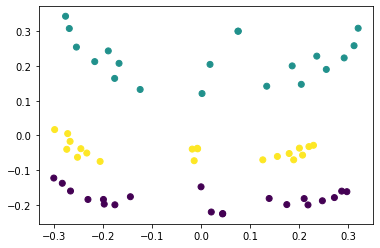

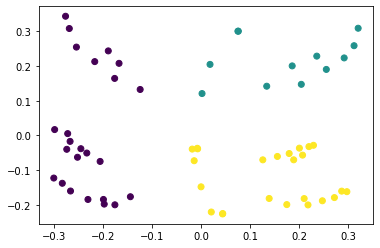

In [401]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_true)
plt.show()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_clusters)
plt.show()

In [402]:
# 3D plot
model = PCA(n_components=3)
X_pca = model.fit_transform(X_data)

kmeans = KMeans(n_clusters=n_classes).fit(X_pca)
pred_clusters = kmeans.labels_


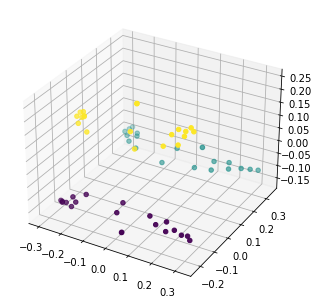

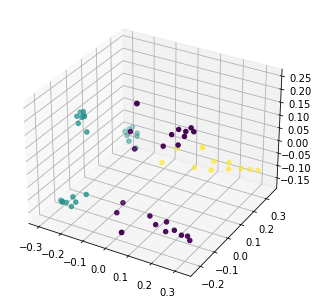

In [403]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels_true)
plt.show()

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=pred_clusters)
plt.show()

In [372]:
output = list()
for j in range(1, 100):
    model = PCA(n_components=j)
    X_pca = model.fit_transform(X_data)
    err = list()

    for i in range(10):
        kmeans = KMeans(n_clusters=n_classes).fit(X_pca)
        pred_clusters = kmeans.labels_

        err.append(clustering_error(labels_true, rearrange_y_pred(pred_clusters, labels_true, n_classes)))

    output.append(np.min(err))

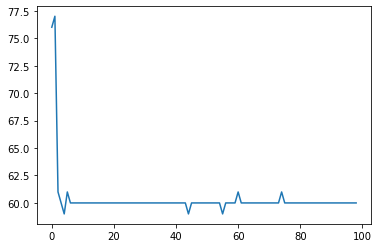

In [373]:
plt.plot(output)

In [370]:
X_data.shape

(100, 4096)

In [371]:
X_pca.shape

(100, 100)

In [319]:
number_list = list()
for i in range(1, 251):
    if i not in [213] :
        number_list.append(f"{i:03d}")


def load_pie_dataset(n_classes):
    id_list = random.sample(number_list, n_classes)
    imgs = []
    for image_idx in id_list:
        for j in [0, 1]:
            for i in range(10):
                filename = f'small_PIE_dataset/{image_idx}/{image_idx}_01_01_051_{j}{i}_crop_128.png'
                img = load_img(filename)
                imgs.append(img)
    X = np.array(imgs)/255
    return X

In [320]:
n_classes = 7
X_data = load_pie_dataset(n_classes=n_classes)
X = X_data.reshape(X_data.shape[0], -1)
scaler = Normalizer()
X = scaler.fit_transform(X)

labels_true = np.arange(n_classes).repeat(20)

n_trials = 50

In [323]:
errors = np.zeros(n_trials)
nmi_list = np.zeros(n_trials)
for i in range(n_trials):
    kmeans = KMeans(n_clusters=n_classes).fit(X)

    pred_clusters = kmeans.labels_
    err = clustering_error(labels_true, rearrange_y_pred(pred_clusters, labels_true, n_classes))
    errors[i] = err
    nmi = normalized_mutual_info_score(labels_true, pred_clusters)
    nmi_list[i] = nmi

print(f'Best error: {np.min(errors):.2f}%')
print(f'Best NMI: {np.max(nmi_list):.2f}')

Best error: 45.00%
Best NMI: 0.66


In [5]:
model = models.RobustPCA()
L, S = model.fit(X)

errors = np.zeros(n_trials)

U, S, Q = np.linalg.svd(L, full_matrices=False)
Q = L @ Q.T

for i in range(n_trials):
    kmeans = KMeans(n_clusters=n_classes).fit(Q)

    pred_clusters = kmeans.labels_
    err = clustering_error(labels_true, pred_clusters)
    errors[i] = err

print(f'Best error: {np.min(errors):.2f}%')

Best error: 60.00%


In [8]:
from sklearn.decomposition import PCA

errors = np.zeros(n_trials)
model = PCA()
X_pca = model.fit_transform(X)

for i in range(n_trials):
    kmeans = KMeans(n_clusters=n_classes).fit(X_pca)

    pred_clusters = kmeans.labels_
    err = clustering_error(labels_true, pred_clusters)
    errors[i] = err

print(f'Best error: {np.min(errors):.2f}%')

Best error: 56.00%
